# Kalman Filter Model

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from DataCollect import BoxSpreadData
from SignalGenerator import SignalGenerator

## Box Rate

In [5]:
def get_data() -> pd.DataFrame:
    
    df_fut = BoxSpreadData().get_tsy_fut()

    df_signal = (SignalGenerator().kalman_filter().query(
        "data_source == 'box'").
        drop(columns = ["data_source"]))
    
    return df_fut, df_signal

df_fut, df_signal = get_data()

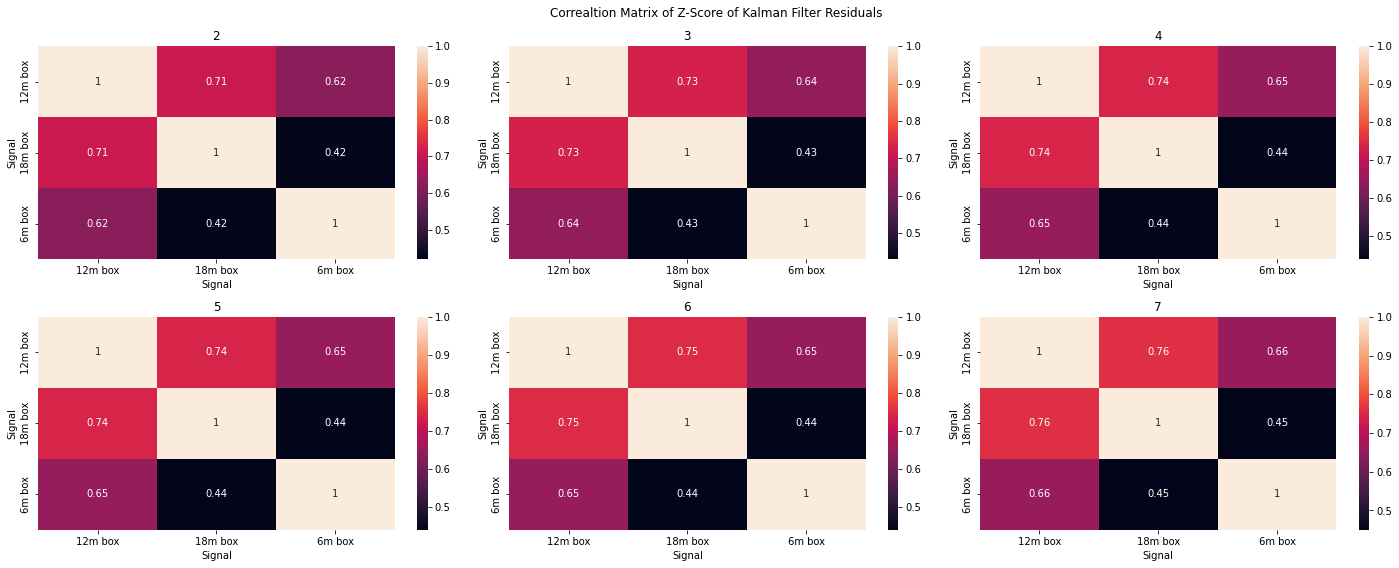

In [28]:
def plot_correlation(df_signal: pd.DataFrame) -> plt.Figure: 
    
    lookbacks = df_signal.lookback.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(lookbacks) // 2, nrows = len(lookbacks) // 3, figsize = (20,8))

    for lookback, ax in zip(lookbacks, axes.flatten()):

        df_plot = (df_signal.query(
            "lookback == @lookback")
            [["date", "group_var", "lag_zscore"]].
            rename(columns = {"group_var": "Signal"}).
            pivot(index = "date", columns = "Signal", values = "lag_zscore").
            corr().
            apply(lambda x: np.round(x, 2)))

        sns.heatmap(
            ax    = ax,
            annot = True,
            data  = df_plot)

        ax.set_title(lookback)

    fig.suptitle("Correaltion Matrix of Z-Score of Kalman Filter Residuals")
    plt.tight_layout()
    
plot_correlation(df_signal)

In [37]:
def apply_signal(df_fut: pd.DataFrame, df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (df_fut.drop(
        columns = ["PX_LAST", "duration"]).
        merge(right = df_signal[["date", "group_var", "lookback", "lag_zscore"]], how = "inner", on = ["date"]).
        assign(
            strat_name = lambda x: x.security + " " + x.group_var + " " + x.lookback.astype(str),
            signal_rtn = lambda x: -1 * np.sign(x.lag_zscore) * x.PX_RTN,
            signal_bps = lambda x: -1 * np.sign(x.lag_zscore) * x.PX_BPS))
    
    return df_combined

df_signal_rtn = apply_signal(df_fut, df_signal)

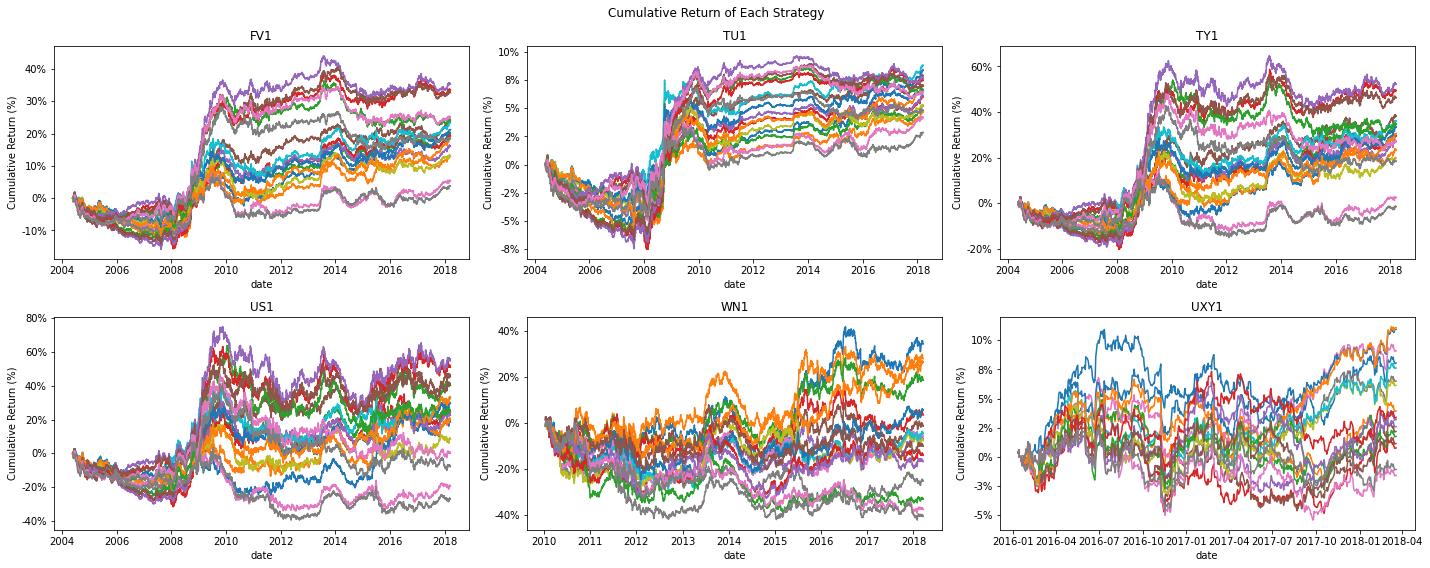

In [43]:
def plot_cumulative_returns(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    securities = df_signal_rtn.security.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 3, figsize = (20,8))

    for security, ax in zip(securities, axes.flatten()):

        (df_signal_rtn.query(
            "security == @security").
            assign(tmp_signal = lambda x: x.group_var + " " + x.lookback.astype(str))
            [["tmp_signal", "date", "signal_rtn"]].
            pivot(index = "date", columns = "tmp_signal", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                ylabel = "Cumulative Return (%)",
                title  = security))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("Cumulative Return of Each Strategy")
    plt.tight_layout()
    
plot_cumulative_returns(df_signal_rtn)

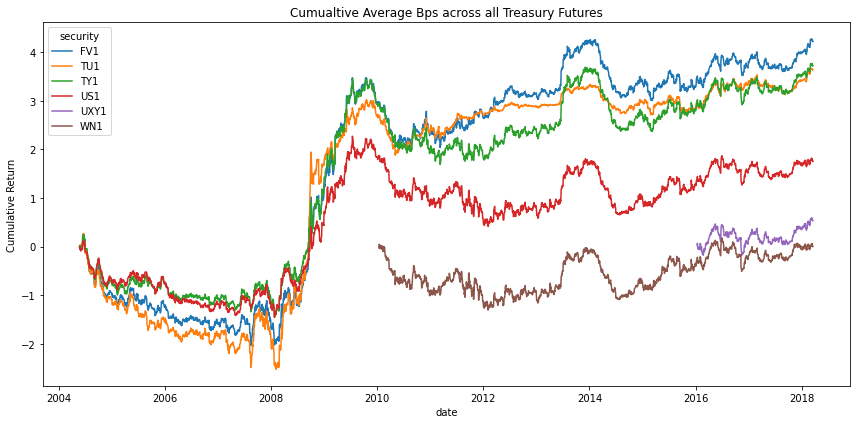

In [49]:
def plot_average_cumulative_basis_points(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_signal_rtn[
        ["date", "security", "signal_bps"]].
        groupby(["date", "security"]).
        agg("mean").
        reset_index().
        pivot(index = "date", columns = "security", values = "signal_bps").
        cumsum().
        plot(
            ax     = axes,
            ylabel = "Cumulative Return",
            title  = "Cumualtive Average Bps across all Treasury Futures"))
    
    plt.tight_layout()
    
plot_average_cumulative_basis_points(df_signal_rtn)

In [55]:
def _rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            roll_sharpe     = lambda x: x.signal_bps.rolling(window = window).mean() / x.signal_bps.rolling(window = window).std(),
            lag_roll_sharpe = lambda x: x.roll_sharpe.shift()))

def get_rolling_sharpe(df_signal_rtn: pd.DataFrame, window = 30) -> pd.DataFrame: 

    df_roll_sharpe = (df_signal_rtn.assign(
        group_var = lambda x: security + " " + x.group_var + " " + x.lookback.astype(str)).
        groupby("group_var").
        apply(_rolling_sharpe, window).
        reset_index(drop = True).
        dropna())
    
    return df_roll_sharpe

df_roll_sharpe = get_rolling_sharpe(df_signal_rtn)

In [73]:
def _get_opt_strategies(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.query(
        "lag_roll_sharpe == lag_roll_sharpe.min() | lag_roll_sharpe == lag_roll_sharpe.max()").
        sort_values("lag_roll_sharpe").
        groupby("lag_roll_sharpe").
        head(1).
        assign(strat = ["min_sharpe", "max_sharpe"]))

    return df_out
    
def get_opt_strategies(df_roll_sharpe: pd.DataFrame) -> pd.DataFrame:
    
    df_opt = (df_roll_sharpe.groupby(
        ["security", "date"]).
        apply(_get_opt_strategies).
        reset_index(drop = True))
    
    return df_opt

df_opt = get_opt_strategies(df_roll_sharpe)

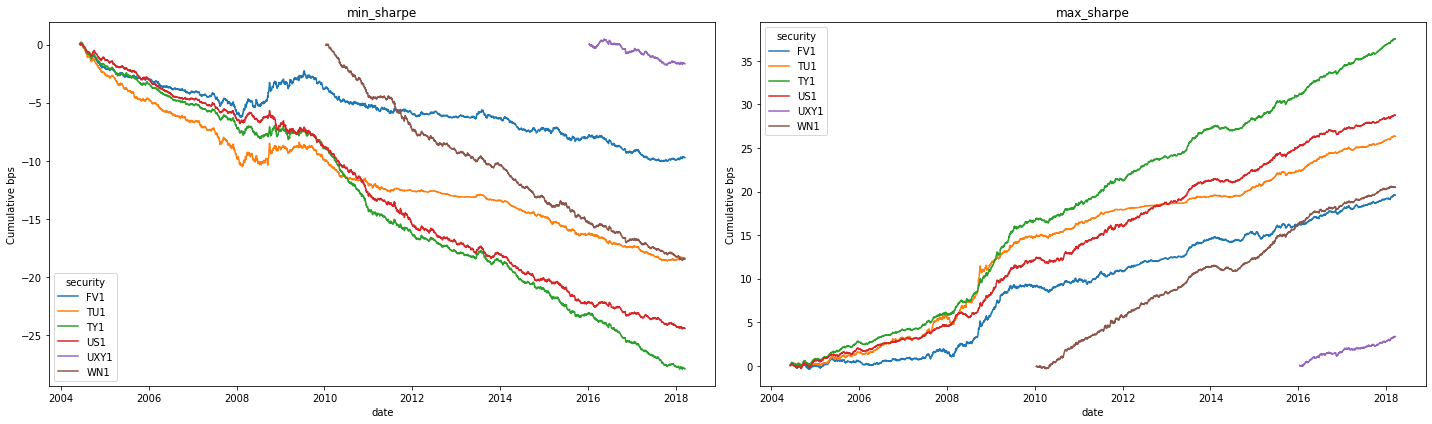

In [87]:
def plot_groups(df_opt: pd.DataFrame) -> pd.DataFrame: 
    
    groups    = df_opt.strat.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))

    for group, ax in zip(groups, axes.flatten()):

        (df_opt.query(
            "strat == @group")
            [["date", "security", "signal_bps"]].
            pivot(index = "date", columns = "security", values = "signal_bps").
            cumsum().
            plot(
                ax      = ax,
                ylabel  = "Cumulative bps",
                title   = group))
        
    plt.tight_layout()
    
plot_groups(df_opt)

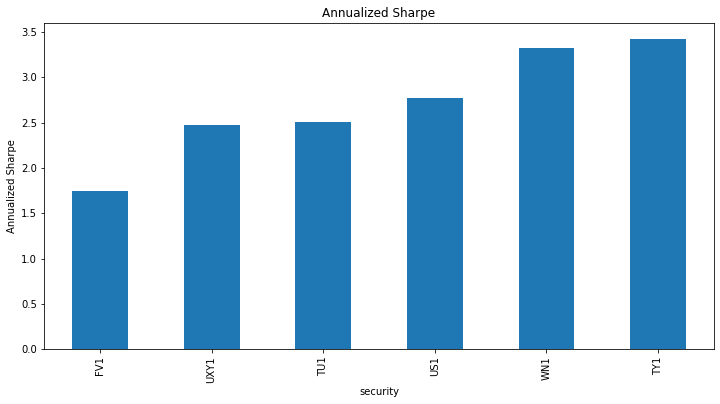

In [92]:
def plot_sharpe(df_opt: pd.DataFrame) -> plt.Figure: 
    
    (df_opt.query(
        "strat == 'max_sharpe'")
        [["security", "signal_rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        sort_values("sharpe")
        [["sharpe"]].
        plot(
            figsize = (12,6),
            kind    = "bar",
            legend  = False,
            title   = "Annualized Sharpe",
            ylabel  = "Annualized Sharpe"))
    
plot_sharpe(df_opt)

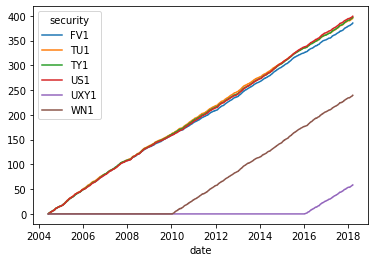

In [110]:
def _get_tc(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_pos = lambda x: x.pos.shift()).
        dropna().
        query("pos != lag_pos")
        [["date", "security"]].
        assign(cost = 0.25))
    
    return df_out

def get_tc(df_opt: pd.DataFrame) -> plt.Figure: 

    (df_opt.assign(
        pos = lambda x: np.sign(x.lag_zscore)).
        query("strat == 'max_sharpe'").
        groupby("security").
        apply(_get_tc).
        reset_index(drop = True).
        pivot(index = "date", columns = "security", values = "cost").
        fillna(0).
        cumsum().
        plot())
    
get_tc(df_opt)

In [118]:
def _get_opt_mid_strategies(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.query(
        "lag_roll_sharpe >= 0").
        query("lag_roll_sharpe == lag_roll_sharpe.min()").
        groupby("lag_roll_sharpe").
        head(1))

    return df_out
    
df_opt = (df_roll_sharpe.groupby(
    ["security", "date"]).
    apply(_get_opt_mid_strategies).
    reset_index(drop = True))

In [144]:
test = r"C:\Users\Diego\Desktop\app_prod\BBGData\ETFIndices\BondPricing\TLT.parquet"

In [148]:
(pd.read_parquet(path = test).drop(
    columns = ["security"]).
    pivot(index = "date", columns = "variable", values = "value"))

variable,AVERAGE_WEIGHTED_COUPON,YAS_BOND_YLD,YAS_ISPREAD_TO_GOVT,YAS_MOD_DUR,YAS_YLD_SPREAD
date,,,,,
2013-01-02,3.9471,2.9316,-1.7447,17.7117,6.4378
2013-01-03,3.9471,3.0094,-2.2163,17.6250,5.9512
2013-01-04,3.9471,2.9883,-1.6225,17.6416,-5.3581
2013-01-07,3.9471,2.9859,-2.2106,17.6441,-5.5968
2013-01-08,3.9272,2.9518,-2.6560,17.7109,-14.5421
...,...,...,...,...,...
2024-10-23,2.7323,4.5946,4.4963,16.4342,7.4935
2024-10-24,2.7356,4.5564,4.9754,16.4670,8.1462
2024-10-25,2.7356,4.5928,5.8324,16.4249,9.2365


<AxesSubplot:xlabel='date'>

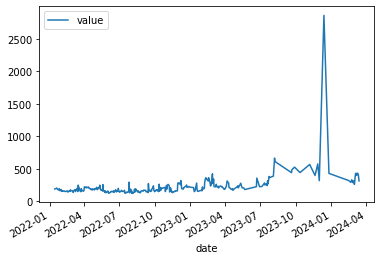

In [189]:
file = r"C:\Users\Diego\Desktop\app_prod\BBGData\EquityData\Volatilities\MI_2M_CALL_IMP_VOL_25DELTA_DFLT.parquet"
(pd.read_parquet(
    path = file, engine = "pyarrow").
    set_index("date")
    [["value"]].
    plot())